In [1]:
# CNN + LSTM + Multi-Head-Attention 的结构

In [2]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt

In [3]:
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

# np.random.seed(1027)
# torch.manual_seed(1027)
# torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

In [4]:
# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
# dataset = pd.read_csv("601229_price_qfq_137dims.csv", index_col=0)
# dataset = pd.read_csv("601229_price_qfq_137dims_part.csv", index_col=0)
# dataset = dataset.drop(['date'], axis=1)
dataset = dataset.fillna(0)
# if dataset.shape[0] %2 == 1:                                                  # 因为 position_encoding需要偶数的dim，才能对称
#     dataset['dummy'] = 0
print(dataset.shape)
print(dataset.shape)
print(dataset.columns)

(1284, 136)
(1284, 136)
Index(['future', 'close', 'hl_pct', 'co_pct', 'vm5_pct', 'close-sma5',
       'close-sma10', 'close-sma30', 'close-sma60', 'close-sma90',
       ...
       'max5-max30', 'max5-max60', 'max10-max30', 'max10-max60', 'max30-max60',
       'mon', 'tue', 'wed', 'thr', 'fri'],
      dtype='object', length=136)


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
dataset['close'] = scaler.fit_transform(dataset['close'].values.reshape(-1,1))
dataset['close']

date
2017-02-16    0.342196
2017-02-17    0.237633
2017-02-20    0.501175
2017-02-21    0.422768
2017-02-22    0.361798
                ...   
2022-05-23   -0.962899
2022-05-24   -1.000000
2022-05-25   -0.987633
2022-05-26   -0.962899
2022-05-27   -0.956715
Name: close, Length: 1284, dtype: float64

In [6]:
# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
TRAIN_VALIDATION_RATIO = 0.9
TRAIN_BATCH_SIZE = 8                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_SIZE = 1
SEQ_LENGTH = 25
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

# 打乱train数据
# np.random.shuffle(rolling_data)

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))

# TEST_BATCH_COUNT  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
TEST_BATCH_SIZE  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
if TEST_BATCH_SIZE == 0:                                                                   # 如果 rolling_data 刚好被整除，那就专门留一整块给test，全部算一个batch
    TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
TEST_BATCH_COUNT = 1
TRAIN_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) * TRAIN_VALIDATION_RATIO)
VALID_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) - TRAIN_BATCH_COUNT)

print("TRAIN_BATCH_COUNT : {}".format(TRAIN_BATCH_COUNT))
print("VALID_BATCH_COUNT : {}".format(VALID_BATCH_COUNT))
print("TEST_BATCH_COUNT  : {}".format(TEST_BATCH_COUNT))

# train = rolling_data[:-test_seq_count].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
# test  = rolling_data[-test_seq_count:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = rolling_data[:TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE].reshape(TRAIN_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
valid = rolling_data[TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE:-TEST_BATCH_COUNT*TEST_BATCH_SIZE].reshape(VALID_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)     # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-TEST_BATCH_COUNT*TEST_BATCH_SIZE:].reshape(TEST_BATCH_COUNT, TEST_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

TRAIN_BATCH_COUNT = train.shape[0]
TRAIN_BATCH_SIZE = train.shape[1]
VALID_BATCH_COUNT = valid.shape[0]
VALID_BATCH_SIZE = valid.shape[1]
TEST_BATCH_COUNT = test.shape[0]
TEST_BATCH_SIZE = test.shape[1]

train = torch.tensor(train)
valid = torch.tensor(valid)
test  = torch.tensor(test)


train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
valid_x, valid_y = valid[:,:,:,Y_SEQ_LEN:], valid[:,:,-1:,0:Y_SEQ_LEN]           # [valid_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
valid_y = valid_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]


train_x = train_x.to(device)
train_y = train_y.to(device)
valid_x = valid_x.to(device)
valid_y = valid_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("valid_x: {}".format(valid_x.shape))
print("valid_y: {}".format(valid_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("valid_batch_count: {}".format(valid.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (1260, 25, 136)
seq count: 1260
seq length: 25
TRAIN_BATCH_COUNT : 141
VALID_BATCH_COUNT : 16
TEST_BATCH_COUNT  : 1
train_x: torch.Size([141, 8, 25, 135])
train_y: torch.Size([141, 8, 1, 1])
valid_x: torch.Size([16, 8, 25, 135])
valid_y: torch.Size([16, 8, 1, 1])
test_x:  torch.Size([1, 4, 25, 135])
test_y:  torch.Size([1, 4, 1, 1])
train_batch_count: 141
valid_batch_count: 16
test_batch_count:  1


In [7]:



# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim_size, num_layers, output_size, dropout=0):
        super().__init__()
        self.hidden_size = hidden_dim_size
        self.sequence_length = SEQ_LENGTH
        self.num_layers = num_layers  
        self.output_size = output_size
        self.input_dim_size = input_size
        

        self.dropout = nn.Dropout(dropout)
        
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout, bidirectional=False)
     
        self.layer_norm = nn.LayerNorm(self.input_dim_size, elementwise_affine=False)
        
        
        self.linear_1 = nn.Linear(1*self.hidden_size, self.output_size)          # 这个是将输入的维度转换成 hidden_dim 的
        
        
        self.relu = nn.LeakyReLU()                                       # 用 relu 来增强模型非线性
        
        # self.query = nn.Linear(self.hidden_size, self.hidden_size)     # 输入768， 输出多头的维度总数。这里还是768.
        # self.key = nn.Linear(self.hidden_size, self.hidden_size)       # 输入768， 输出多头的维度总数。这里还是768.
        # self.value = nn.Linear(self.hidden_size, self.hidden_size)     # 输入768， 输出多头的维度总数。这里还是768.
        
        self.att_input_dim_size = 2 * self.hidden_size
        self.num_attention_head = 4                                                                  # 64
        self.attention_head_size = int(self.att_input_dim_size/self.num_attention_head)                      # 每个头是32个维度
        self.all_head_size = self.num_attention_head * self.attention_head_size                       # 所有的头的维度合集
        self.query = nn.Linear(self.att_input_dim_size, self.all_head_size)     # 输入768， 输出多头的维度总数。这里还是768.
        self.key = nn.Linear(self.att_input_dim_size, self.all_head_size)       # 输入768， 输出多头的维度总数。这里还是768.
        self.value = nn.Linear(self.att_input_dim_size, self.all_head_size)     # 输入768， 输出多头的维度总数。这里还是768.
        self.att_linear = nn.Linear(self.att_input_dim_size, self.att_input_dim_size)    # 这个是给最后的多头注意力再乘 W0 的
  
        # self.init_weights_orth()
        self.init_weights_mix()

    def init_weights_mix(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            else:
                nn.init.kaiming_uniform_(param)

    def attention_net(self, in_value, mask=None):

        batch_size = in_value.shape[0]
        seq_len = in_value.shape[1]
        hidden_dim = in_value.shape[2]

        
        
        # Q : [batch_size, seq_len, hidden_dim] ==> [batch_size, seq_len, num_head, head_size] ==> [batch_size, num_head, seq_len, head_size]
        Q = self.query(in_value).reshape(batch_size, seq_len, self.num_attention_head, self.attention_head_size).permute(0, 2, 1, 3)      # 先将 hidden_dim 切成 num_head * head_size ，再将 num_head 和 seq_len互换
        K = self.key(in_value).reshape(batch_size, seq_len, self.num_attention_head, self.attention_head_size).permute(0, 2, 1, 3)        # 先将 hidden_dim 切成 num_head * head_size ，再将 num_head 和 seq_len互换
        V = self.value(in_value).reshape(batch_size, seq_len, self.num_attention_head, self.attention_head_size).permute(0, 2, 1, 3)      # 先将 hidden_dim 切成 num_head * head_size ，再将 num_head 和 seq_len互换
        
        # d_k = Q.size(-1)                                                                            # d_k为query的维度。避免概率接近0
        
        # attention_scores = torch.matmul(query, lstm_output.transpose(1, 2)) / math.sqrt(d_k)     #打分机制  [batch_size, seq_len, hid_dim] * [batch_size, hid_dim, seq_len] ==> scores:[batch_size, seq_len, seq_len], 每个值就是两个输入x元素的相似性
        attention_scores = torch.matmul(Q, K.transpose(-1, -2))                                    # [batch_size, num_head, seq_len, head_size] * [batch_size, num_head, head_size, seq_len] ==> [batch_size, num_head, seq_len, seq_len]
        
        # attention_scores = attention_scores / math.sqrt(d_k)                                       # [batch_size, seq_len, seq_len]
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)                  # 多头机制下，hidden-dim被划分为 num_head个区域，所以现在要除的就是每个小区域的维度开方
        
        # alpha = F.softmax(attention_scores, dim = -1)                                            #对最后一个维度归一化得分  [batch_size, seq_len, seq_len] 保证相似性在一行上归一了。
        alpha = nn.Softmax(dim=-1)(attention_scores)                                               # 因为alpha是方阵，0维的seq_len就是真正的序列长度，1维的seq_len是对应每一个element和序列元素相关性。
        
        # alpha = self.dropout(alpha)

        attention = torch.matmul(alpha, V)                                            # [batch_size, num_head, seq_len, seq_len] * [batch_size, num_head, seq_len, head_size] = [batch_size, num_head, seq_len, head_size]
        
        attention = attention.permute(0, 2, 1, 3).contiguous()                        # [batch_size, num_head, seq_len, head_size] ==> [batch_size, seq_len, num_head, head_size]
        # new_attention_shape = attention.size()[:-2] + (self.all_head_size,)
        # attention = attention.view(*new_attention_shape)
        attention = attention.reshape(batch_size, seq_len, self.all_head_size)
        
        attention = self.att_linear(attention)
        
        return attention      
        
    
    def forward(self, x):
        
        x = x.float()
        
        h1 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().float().to(device)
        c1 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().float().to(device)
        
        x_output, _ = self.lstm1(x, (h1.detach(), c1.detach()))

        predictions = self.linear_1(x_output)
        
        return predictions


In [8]:
# 训练 LSTM 模型 ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异

HIDDEN_SIZE = 1024
NUM_LAYERS = 2

def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

# model = LSTMModel(input_size=train_x.shape[3], hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, seq_len=train_x.shape[2], output_size=1).float().to(device)
model = LSTMModel(input_size=X_DIM, hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).float().to(device)
LR = 1e-6
# loss_func = nn.MSELoss(reduction="mean")
loss_func = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0, last_epoch=-1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, last_epoch=-1)

9 of 2000 epoch 	 train_loss: 0.649 	 train_MAPE: 8.21% 	 train_r2: -143.868 	 valid_loss: 1.084 	 valid_MAPE: 15.68% 	 valid_r2: -1299.496
19 of 2000 epoch 	 train_loss: 0.444 	 train_MAPE: 5.45% 	 train_r2: -55.467 	 valid_loss: 0.947 	 valid_MAPE: 13.78% 	 valid_r2: -874.069
29 of 2000 epoch 	 train_loss: 0.401 	 train_MAPE: 4.88% 	 train_r2: -47.240 	 valid_loss: 0.876 	 valid_MAPE: 12.76% 	 valid_r2: -716.823
39 of 2000 epoch 	 train_loss: 0.383 	 train_MAPE: 4.65% 	 train_r2: -42.713 	 valid_loss: 0.816 	 valid_MAPE: 11.89% 	 valid_r2: -604.109
49 of 2000 epoch 	 train_loss: 0.368 	 train_MAPE: 4.46% 	 train_r2: -38.879 	 valid_loss: 0.763 	 valid_MAPE: 11.12% 	 valid_r2: -514.951
59 of 2000 epoch 	 train_loss: 0.355 	 train_MAPE: 4.29% 	 train_r2: -35.535 	 valid_loss: 0.716 	 valid_MAPE: 10.43% 	 valid_r2: -442.306
69 of 2000 epoch 	 train_loss: 0.344 	 train_MAPE: 4.14% 	 train_r2: -32.793 	 valid_loss: 0.676 	 valid_MAPE: 9.86% 	 valid_r2: -386.336
79 of 2000 epoch 	 train_lo

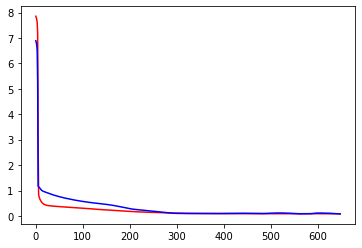

min train loss: 0.086
min valid loss: 0.080


In [9]:
def ACC(y_hat, y_real):
    y_real = np.array(y_real) + 1
    y_hat = np.array(y_hat) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((y_real - y_hat) / y_real)))
    return percentage * 100

# 定义 RMSE 损失函数。因为torch没有。
def RMSE(y_hat, y):
    return torch.sqrt(torch.mean((y_hat-y)**2))


# 定义 MAPE 计算函数。平均绝对百分比误差：不受量纲影响。但y接近0时受极端值影响。为（0%）表示完美模型，MAPE 大于 （100%）则表示劣质模型。
def MAPE(y_hat, y):
    absolute_percent_error = (torch.abs(y_hat-y)+1e-7)/(torch.abs(y)+1e-7)
    return torch.mean(absolute_percent_error)

# 定义了 R2 的计算函数。决定系数：反映因变量的全部变异能通过回归关系被自变量解释的比例。
# R2<=1，R2为1时说明预测模型不犯任何错误；R2为0时说明预测模型等于基准模型；R2小于0说明预测模型不如基准模型，可能数据不存在任何线性关系。
def R2(y_hat, y):
    y_mean = torch.mean(y)
    ss_tot = torch.sum((y - y_mean) ** 2)
    ss_res = torch.sum((y - y_hat) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

# 定义 SMAPE 计算函数。修复了原始MAPE的缺点-它同时具有下限（0％）和上限（200％)
def SMAPE(y_hat, y):
    absolute_percent_error = (torch.abs(y_hat-y)+1e-7)/(torch.abs(y_hat)+torch.abs(y)+1e-7)
    return 2.0 * torch.mean(absolute_percent_error)



# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epochs = 2000
train_epoch_loss = 0
train_epoch_loss_list = []
train_epoch_acc_list = []
valid_epoch_loss = 0
valid_epoch_loss_list = []
valid_epoch_acc_list = []

train_batch_count = train_x.shape[0]
valid_batch_count = valid_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)


for epoch in range(epochs):
    batch_loss = []
    batch_mape = []
    batch_r2   = []
    train_epoch_loss = 0
    train_epoch_mape = 0
    train_epoch_r2 = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0, train_batch_count))
    # random.shuffle(train_batch_list)
    for step in train_batch_list:
        train_pred = model(train_x[step])                                                    # pred: [batch_size, seq_len, out_dim]  但被修改成了 [batch_size, 1, out_dim]
        loss = loss_func(train_pred[:, -1, -1], train_y[step][:, -1, -1])                                    # 取batch里每个sequence最后一个预测输出来和实际
        train_pred_value_list.extend(list(train_pred[:, -1, -1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step][:, -1, -1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
        batch_mape.append(MAPE(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
        batch_r2.append(R2(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
    # print(batch_mape)
    train_epoch_loss = np.mean(batch_loss)
    train_epoch_mape = np.mean(batch_mape)
    train_epoch_r2 = np.mean(batch_r2)

    batch_loss = []
    batch_mape = []
    batch_r2 = []
    valid_epoch_loss = 0
    valid_epoch_mape = 0
    valid_epoch_r2 = 0
    valid_pred_value_list = []
    valid_real_value_list = []
    for step in range(valid_batch_count):
        valid_pred = model(valid_x[step])
        loss = loss_func(valid_pred[:, -1, -1], valid_y[step][:, -1, -1])
        valid_pred_value_list.extend(list(valid_pred[:, -1, -1].cpu().detach().flatten().numpy()))
        valid_real_value_list.extend(list(valid_y[step][ :, -1, -1].cpu().detach().flatten().numpy()))
        batch_loss.append(loss.cpu().data.numpy())
        batch_mape.append(MAPE(valid_pred[:, -1, -1], valid_y[step][:, -1, -1]).item())
        batch_r2.append(R2(valid_pred[:, -1, -1], valid_y[step][:, -1, -1]).item())
    # print(batch_loss)
    valid_epoch_loss = np.mean(batch_loss)
    valid_epoch_mape = np.mean(batch_mape)
    valid_epoch_r2 = np.mean(batch_r2)


    valid_epoch_loss_list.append(valid_epoch_loss)
    train_epoch_loss_list.append(train_epoch_loss)

    if ((epoch+1) % 10) == 0:
        print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f} \t valid_loss: {:.3f} \t valid_MAPE: {:.2%} \t valid_r2: {:.3f}".format(epoch, epochs, train_epoch_loss, train_epoch_mape, train_epoch_r2, valid_epoch_loss, valid_epoch_mape, valid_epoch_r2))

    if valid_epoch_loss < 0.08:
        print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f} \t valid_loss: {:.3f} \t valid_MAPE: {:.2%} \t valid_r2: {:.3f}".format(epoch, epochs, train_epoch_loss, train_epoch_mape, train_epoch_r2, valid_epoch_loss, valid_epoch_mape, valid_epoch_r2))
        print("****************************************** STOP TRAIN  ****************************************")
        break

plt.plot(train_epoch_loss_list, 'r-')
plt.plot(valid_epoch_loss_list, 'b-')
plt.show()
print("min train loss: {:.3f}".format(min(train_epoch_loss_list)))
print("min valid loss: {:.3f}".format(min(valid_epoch_loss_list)))

In [10]:
# # 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
# model.train()
# epoches = 2000
# train_epoch_loss = 0
# train_epoch_loss_list = []
# valid_smallest_loss = 1
# valid_smallest_epoch = 0
# valid_epoch_loss = 0
# valid_epoch_loss_list = []

# train_batch_count = train_x.shape[0]
# valid_batch_count = valid_x.shape[0]


# for epoch in range(epoches):
#     batch_loss = []
#     train_epoch_loss = 0
#     train_pred_value_list = []
#     train_real_value_list = []
#     train_batch_list = list(range(0,train_batch_count))
#     # random.shuffle(train_batch_list)
#     for step in train_batch_list:
#         train_pred = model(train_x[step])
#         # h0, c0 = hn.detach(), cn.detach()
#         loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
#         train_pred_value_list.extend(list(train_pred[:,-1].cpu().detach().flatten().numpy() ))
#         train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
#         optimizer.step()
#         batch_loss.append(loss.cpu().data.numpy())
#     # print(batch_loss)
#     train_epoch_loss = np.mean(batch_loss)

#     batch_loss = []
#     valid_epoch_loss = 0
#     valid_pred_value_list = []
#     valid_real_value_list = []
#     for step in range(valid_batch_count):
#         valid_pred = model(valid_x[step])
#         loss = loss_func(valid_pred[:,-1,-1], valid_y[step][:,-1,-1])
#         valid_pred_value_list.extend(list(valid_pred[:,-1,-1].cpu().detach().flatten().numpy()))
#         valid_real_value_list.extend(list(valid_y[step][:,-1,-1].cpu().detach().flatten().numpy()))
#         batch_loss.append(loss.cpu().data.numpy())

#     # print(batch_loss)
#     valid_epoch_loss = np.mean(batch_loss)
    

#     valid_epoch_loss_list.append(valid_epoch_loss)
#     train_epoch_loss_list.append(train_epoch_loss)

#     if ((epoch+1) %10) == 0:
#         print("{} of {} epoch   train_loss: {:.3f}   valid_loss: {:.3f}".format(epoch, epoches, train_epoch_loss, valid_epoch_loss))
    
#     if valid_epoch_loss <= 0.1:
#         print("************************** STOP TRAIN ******************************")
#         print("{} of {} epoch   train_loss: {:.3f}   valid_loss: {:.3f}".format(epoch, epoches, train_epoch_loss, valid_epoch_loss))
#         break
    
# plt.plot(train_epoch_loss_list, 'r-')
# plt.plot(valid_epoch_loss_list, 'b-')
# plt.show()  
# print("min train loss: {:.3f}".format(min(train_epoch_loss_list)))
# print("min valid loss: {:.3f}".format(min(valid_epoch_loss_list)))

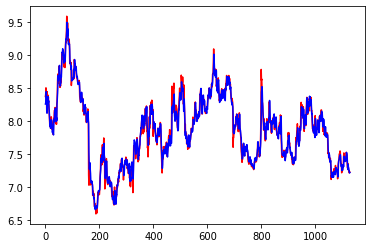

In [11]:
# 这是 train 的预测图形
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()
# print(train_real_value_list)

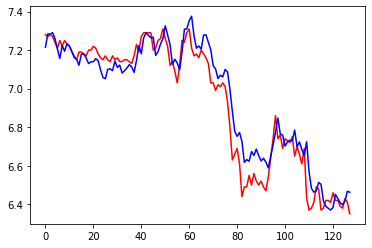

In [12]:
# 这是 vali的预测图形
plt.plot(valid_real_value_list, 'r-')
plt.plot(valid_pred_value_list, 'b-')
plt.show()

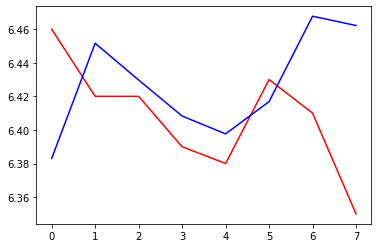

[6.46 6.42 6.42 6.39 6.38 6.43 6.41 6.35]
[6.3830023 6.4516344 6.4297414 6.4082837 6.397659  6.416882  6.46771
 6.462189 ]


In [13]:
# 这是 valid 最后一段的数据。误差累积到这里已经很大了。
plt.plot(valid_y[-1,:,-1,-1].cpu().detach().flatten().numpy(), 'r-')
plt.plot(valid_pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
plt.show()
# print(valid_y[-1,:,-1,-1].cpu().detach().flatten().numpy())
# print(valid_pred[:,-1].cpu().detach().flatten().numpy())

In [14]:
# 用模型预测数据
# 考虑到时序因素，这里的时候误差很大。
model.eval()
test_loss = 0

for step in range(test_x.shape[0]):
    pred = model(test_x[step])
    
    loss = loss_func(pred[:,-1,-1], test_y[step][:,-1,-1])               # Compare the all sequences' last element in one batch
    
    if test_x.shape[0] > 1:
        actual_line.append(test_y[step][-1,-1].item())
        pred_line.append(pred[-1,-1].item())
    elif test_x.shape[0] == 1:
        actual_line = test_y[step].cpu().detach().flatten().numpy()        # Only plot the last sequence of test batch
        pred_line   = pred[:,-1].cpu().detach().flatten().numpy()                # Only plot the last sequence of test batch
        
# print("Test Loss : {:.3f}".format(loss.data))
print("Prediction: {:.2f}".format(float(pred[-1,-1].data)))
print("Actual:     {:.2f}".format(float(test_y[step][-1,-1].data)))


# plt.plot(test_y[step,:,-1,-1].cpu().detach().flatten().numpy(), 'r--')
# plt.plot(pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
# plt.show()
# print(test_y[step,:,-1,-1].cpu().detach().flatten().numpy())
print(pred[:,].cpu().detach().flatten().numpy())

Prediction: 6.45
Actual:     0.00
[0.04019247 0.10118229 0.20167765 0.3212964  0.46112615 0.64506584
 0.7905736  0.9483531  1.1521598  1.3963219  1.6867135  1.9952607
 2.2827978  2.6246126  3.0201762  3.4374745  3.8775318  4.357533
 4.765704   5.144286   5.4680996  5.7819123  6.0867133  6.2887993
 6.3837132  0.02626743 0.10196327 0.20097268 0.32231736 0.48567533
 0.61638194 0.7578623  0.94116503 1.1615386  1.4237568  1.7026895
 1.9621947  2.2724123  2.6357627  3.0262408  3.4486814  3.9227824
 4.346274   4.7561407  5.1245103  5.4885154  5.8438787  6.094664
 6.231678   6.4094424  0.03560511 0.10350738 0.19815065 0.33539128
 0.44788265 0.5713469  0.733399   0.9297484  1.1636957  1.4127076
 1.6433256  1.9195825  2.245715   2.6007535  2.9926546  3.443697
 3.8642516  4.289186   4.6917405  5.102924   5.513051   5.8228407
 6.0148463  6.237676   6.444163   0.0294299  0.09605362 0.20663875
 0.3007502  0.4070922  0.5498508  0.7249438  0.9341693  1.1571273
 1.362557   1.6084019  1.8996439  2.21880

In [15]:
# 保存模型
torch.save(model, 'e:\\M_CNN_LSTM_ADV3.pkl')